In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

Levin, Bruce R., Jeniffer Concepción-Acevedo, and Klas I. Udekwu. 2014. “Persistence: A Copacetic and Parsimonious Hypothesis for the Existence of Non-Inherited Resistance to Antibiotics.” Current Opinion in Microbiology 21: 18–21. doi:[10.1016/j.mib.2014.06.016](http://www.sciencedirect.com/science/article/pii/S1369527414000861).

Berkley Madonna code [available](http://www.eclf.net/sites/eclf.net/files/ABTreatment%20Model%20Refugia2013.mmd).

In [239]:
Amax = 10 # 150.0 # code
# Table 1 in SI
psi_max = {'S':1.5, 'P': 0.01, 'B': 0.1}
psi_min = {'S': -2.0, 'P': -0.01, 'B': -2.0}
kappa   = {'S': 1.0, 'P': 1.0, 'B': 1.0}
mic     = {'S': 1.0, 'P': 20.0, 'B': 20.0}
w = 0.2
wB = 0.05
C = 1000.
k = 1.
e = 5e-7 # ?? code?
# Fig 1.B red
sp = ps = 1e-6 # 1e-3 # Fig 1
sb = bs = 1e-4

The growth rate $\psi_i(A,R)$ of type $i$ when antiboitics are in concentration $A$ and resources in concentration $R$:
$$
$\psi_i(A,R)$ = \Big( \psi_{MAXi} - (\psi_{MAXi} - \psi_{MINi}) \frac{\frac{A}{MIC(i)}^{\kappa_i}}{\frac{A}{MIC(i)}^{\kappa_i} - \frac{\psi_{MINi}}{\psi_{MAXi}}} \Big) \frac{R}{R+k}
$$

In [240]:
def psi(i,A,R):
    return (psi_max[i] - (psi_max[i] - psi_min[i]) * (A / mic[i])**(kappa[i]) / ( (A / mic[i])**(kappa[i]) - psi_min[i]/psi_max[i]) ) * R/(R + k)

The ODE system is:
$$
\frac{dR}{dt} = w (C-R) - \frac{R}{R+k} e \Big(\psi_{MAXS} S + \psi_{MAXP} P + \psi_{MAXB} B\Big) \\
\frac{dS}{dt} = \psi_S(A,R) S - sp S + ps P - sb S + bs B - w S \\
\frac{dP}{dt} = \psi_P(A,R) P + sp S - ps P - w P \\
\frac{dB}{dt} = \psi_B(A,R) B + sb S - bs B - w_B B \\
\frac{dA}{dt} = -w A
$$
But every $d=24$ hours, $A$ is increased by $A_{max}$.

In [241]:
def dydt(y,t):
    #resources, susceptible, planktonic, resistant, antibiotics
    R,S,P,B,A = y
    dRdt = w * (C - R) - R/(R + k) * e * (psi_max['S'] * S + psi_max['P'] * P + psi_max['B'] * B)
    dSdt = psi('S',A,R) * S - sp * S + ps * P - sb * S + bs * B - w * S
    dPdt = psi('P',A,R) * P + sp * S - ps * P - w * P
    dBdt = psi('B',A,R) * B + sb * S - bs * B - wB * B
    dAdt = -w * A
    return dRdt, dSdt, dPdt, dBdt, dAdt

In [242]:
days = 5
pts_per_day = 100
y0 = 300.0, 1e9, 0, 0, 0 # ?? code?
t = np.linspace(0, 24 * days, pts_per_day * days)
y = np.zeros((len(t), 5))
for day in range(days):
    y[pts_per_day * day:pts_per_day * (day + 1),:] = scipy.integrate.odeint(dydt, y0, t[pts_per_day*  day:pts_per_day * (day + 1)])
    y0 = y[pts_per_day * (day + 1) - 1,:]
    y0[-1] = Amax

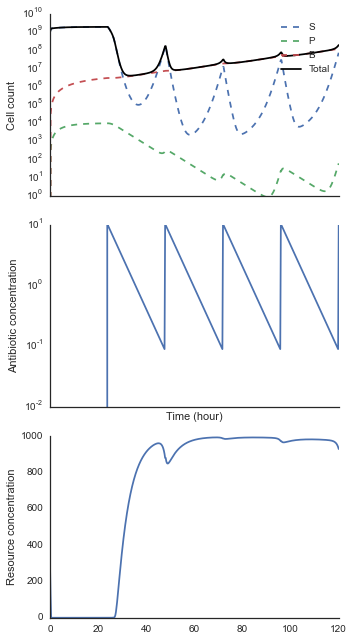

In [244]:
R,S,P,B,A = y.transpose()

fig,ax = plt.subplots(3, 1, sharex=True, figsize=(5,9))
ax[0].plot(t, S, ls='--', label='S')
ax[0].plot(t, P, ls='--', label='P')
ax[0].plot(t, B, ls='--', label='B')
ax[0].plot(t, S+P+B, color='k', label='Total')
ax[0].set_ylabel('Cell count')
ax[0].legend(loc='upper right')
ax[0].set_yscale('log')
ax[0].set_ylim(1,1e10)
ax[1].plot(t, A)
ax[1].set_ylabel('Antibiotic concentration')
ax[1].set_xlabel('Time (hour)')
ax[1].set_yscale('log')
ax[2].plot(t, R)
ax[2].set_ylabel('Resource concentration')
sns.despine()
fig.tight_layout()